*EE5179: Deep Learning for Imaging*

**Akash Sharma (EE21S056)**

#  Preliminaries

## Importing packages

In [1]:
import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics

# A class for beautifying text for plotting and visualization
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Package import completed.' + color.END)

Package import completed.


## Defining utility functions

Some utility functions defined for implementing a multilayer perceptron model from scratch and for experiments to be performed later. Description for the utility functions is given as they are defined. 

### Activation Functions and their Derivatives

To introduce nonlinearities in the model, we use activation functions. For this assignment, the nonlinearities have to be defined using the `sigmoid` function. The other two options which are available are `tanh` and `relu`. However, for the last layer, `softmax` is used for the output.

For backpropagation, the derivatives of these functions are also required. They have been defined below as well.

In [2]:
# Defining activation functions
def sigmoid(x):
  s = 1/(1+np.exp(-x))
  return s

def relu(x):
  s = np.maximum(0,x)
  return s

def tanh(x):
  s = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
  return s

def softmax(x):
  s = np.exp(x)/sum(np.exp(x))
  return s

# Defining derivative of the activation functions (sigmoid, relu, tanh)
def der_sigmoid(x):
  der = sigmoid(x)-(sigmoid(x))**2
  return der

def der_relu(x):
  der = np.int64(x > 0)
  return der

def der_tanh(x):
  der = 1-(tanh(x))**2
  return der

### Initialization

It has been shown that a learning model performs better if it is initialized with non-zero weights, one such initialization is the *Glorot* or *Xavier initialization*. The weights are sampled from a uniform distribution in the interval $[-M,M]$ where $$M = \sqrt{\frac{6}{N_{o}+N_{i}}}$$ $N_{o}$ and $N_{i}$ are number of neurons in the output and input layer respectively. This has been implemented in the code cell below.

In [3]:

def initialize_parameters(layer_dims):

  parameters = {}
  L = len(layer_dims)

  # initialize weights using Glorot Initialization and bias with 0. 
  for l in range(1,L):
    M = np.sqrt(6/(layer_dims[l]+layer_dims[l-1]))
    parameters['W'+ str(l)] = np.random.uniform(-M,M,(layer_dims[l], 
                                                      layer_dims[l-1]))
    parameters['b'+ str(l)] = np.zeros((layer_dims[l],1))

    assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
    assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

  return parameters


### Forward and Backward Propagation

The following function follow the standard implementation of forward and back propagation for 5 layer neural network with 3 hidden layers. These functions are hardcoded according to the number of layers but the neurons in each layer can be changed upon requirement.  

- **Forward Propagation** - All weight, bias and output matrices are calculated and returned in a `cache`, the output of the network is returned as first argument of the function's output. 

- **Backward Propagation** - Returns the gradients required for the gradient descent learning step or optimization. Another variation is the regularized version which implements the $L_{2}$ regularization.

In [4]:
# Get the output of the model
def forward_prop(X, parameters, nonlinear):

  # retrieve parameters
  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  W3 = parameters['W3']
  b3 = parameters['b3']
  W4 = parameters['W4']
  b4 = parameters['b4']

  # LINEAR 1 -> NONLINEAR 1 -> LINEAR 2 -> NONLINEAR 2 -> LINEAR 3 -> 
  # NONLINEAR 3 -> LINEAR 4 -> NONLINEAR 4 -> LINEAR 5 -> SOFTMAX 

  # nonlinear can take the following arguments - tanh, relu, sigmoid

  Z1 = np.dot(W1, X) + b1
  A1 = nonlinear(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = nonlinear(Z2)
  Z3 = np.dot(W3, A2) + b3
  A3 = nonlinear(Z3)
  Z4 = np.dot(W4, A3) + b4
  A4 = softmax(Z4)

  cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4)

  return A4, cache

# Get gradients required for gradient descent optimizer
# der_nonlinear can take the following arguments - der_sigmoid, der_tanh, der_sigmoid
def backward_prop(X, Y, cache, der_nonlinear):

  m = X.shape[1]
  (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4) = cache
  
  dZ4 = A4 - Y
  dW4 = 1./m * np.dot(dZ4, A3.T)
  db4 = 1./m * np.sum(dZ4, axis = 1, keepdims = True)

  dA3 = np.dot(W4.T, dZ4)
  dZ3 = np.multiply(dA3, der_nonlinear(A3))
  dW3 = 1./m * np.dot(dZ3, A2.T)
  db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

  dA2 = np.dot(W3.T, dZ3)
  dZ2 = np.multiply(dA2, der_nonlinear(A2))
  dW2 = 1./m * np.dot(dZ2, A1.T)
  db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
      
  dA1 = np.dot(W2.T, dZ2)
  dZ1 = np.multiply(dA1, der_nonlinear(A1))
  dW1 = 1./m * np.dot(dZ1, X.T)
  db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
  gradients = {"dZ4" : dZ4, "dW4": dW4, "db4" : db4, "dA3": dA3, 
               "dZ3": dZ3, "dW3": dW3, "db3": db3, 
               "dA2": dA2, "dZ2": dZ2, "dW2": dW2, 
               "db2": db2,"dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

  return gradients

# implement L2 regularization in the backward propagation
def backward_prop_regularized(X, Y, cache, lambd, der_nonlinear):

  m = X.shape[1]
  (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3, Z4, A4, W4, b4) = cache

  dZ4 = A4 - Y
  dW4 = 1./m * np.dot(dZ4, A3.T) + (lambd/m)*W4
  db4 = 1./m * np.sum(dZ4, axis = 1, keepdims = True)

  dA3 = np.dot(W4.T, dZ4)
  dZ3 = np.multiply(dA3, der_nonlinear(A3))
  dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
  db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

  dA2 = np.dot(W3.T, dZ3)
  dZ2 = np.multiply(dA2, der_nonlinear(A2))
  dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
  db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
      
  dA1 = np.dot(W2.T, dZ2)
  dZ1 = np.multiply(dA1, der_nonlinear(A1))
  dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
  db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
  gradients = {"dZ4" : dZ4, "dW4": dW4, "db4" : db4, "dA3": dA3, 
               "dZ3": dZ3, "dW3": dW3, "db3": db3, 
               "dA2": dA2, "dZ2": dZ2, "dW2": dW2, 
               "db2": db2,"dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

  return gradients


### Gradient Descent Optimizer

The parameters are updated with the gradient descent optimizer, it follows the standard formulation here.

In [5]:

def update_parameters(parameters, grads, learning_rate):

  n = len(parameters)//2 # Number of layers in neural network

  for k in range(n):
    parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW"+ str(k+1)]
    parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db"+ str(k+1)]
    
  return parameters


### Cost Function

The cost is calculated for each iteration, here the cost function chosen is **cross entropy**. The implementation has been done for the regularized version as well.

In [6]:
def compute_cost(a4, Y):
  m = Y.shape[1]

  logprobs = np.multiply(-np.log(a4),Y) + np.multiply(-np.log(1 - a4), 1 - Y)
  cost = 1./m * np.nansum(logprobs)
    
  return cost

def compute_cost_regularized(a4, Y, parameters, lambd):
  m = Y.shape[1]
  W1 = parameters["W1"]
  W2 = parameters["W2"]
  W3 = parameters["W3"]
  W4 = parameters["W4"]

  logprobs = np.multiply(-np.log(a4),Y) + np.multiply(-np.log(1 - a4), 1 - Y)
  cost = 1./m * np.nansum(logprobs)

  # L2 regularization cost
  L2_regularization_cost = (1/m)*(lambd/2)*(np.sum(np.square(W1)) + 
                                            np.sum(np.square(W2)) + 
                                            np.sum(np.square(W3)) +
                                            np.sum(np.square(W4)))
  return cost


### Preprocessing the dataset

Before feeding the data into the model, it has to be preprocessed. Specifically for MNIST dataset, a single `28*28` images has to be flattened into a one-dimensional vector with `784` elements. These are the feature vectors or the inputs to the model. For the labels, they have to be one-hot encoded as one-dimensional vectors of size `10` such that the output of the model and the label vectors can be used to compute the cost while training.

In [7]:
# Flattens images into 1-D arrays and changes labels to one-hot encoded vectors
def process_dataset(X, Y, batch_size):
  num_ele = X[0].squeeze().flatten().numpy().shape[0]
  # num_labels = torch.unique(Y).numpy().shape[0]
  # hardcoded num_labels because the above line posed problems 
  # when the number of training examples were not perfectly divisible by batch size.
  num_labels = 10 
  x_train = np.zeros((batch_size, num_ele))
  y_train = np.zeros((batch_size, num_labels))

  for i in range(batch_size):
    x_train[i] = X[i].squeeze().flatten().numpy()
    for k in range(num_labels):
      if Y[i] == k:
        y_train[i][k]=1
      else:
        y_train[i][k]=0

  return x_train, y_train


### Neural Network & Epoch Execution

- **NN**:

Using the above functions a neural network function has been implemented which runs for one epoch i.e., when it has gone through all the training examples in the dataset. Depending on the `batch_size`, the number of iterations in the function will change. It returns the learned parameters and the final cost after one epoch. The cost after every 200 iteration is printed and the variation of cost while training for an epoch is plotted.

- **epoch_model**:

This function simply runs the model for the number of epochs selected by the user, after each epoch the parameters obtained are used to initialize the weights and biases for the next epoch. Finally, the variation of cost across the selected number of epochs is plotted.  

In [8]:

def NN(training_data, learning_rate, num_iter, lambd, parameters, batch_size, nonlinear, der_nonlinear, print_cost, show_plot):

  grads = {}
  costs = []
  train_dataloader = DataLoader(training_data, batch_size, shuffle = True)

  for i in range(0, int(num_iter)):
    train_features, train_labels = next(iter(train_dataloader))
    x_train, y_train = process_dataset(train_features, train_labels, batch_size)
    x_train = x_train.T
    y_train = y_train.T
    m = x_train.shape[1]
    
    a4, cache = forward_prop(x_train, parameters, nonlinear)

    # Choose lambd nonzero for regularized model training
    if lambd == 0:
      cost = compute_cost(a4, y_train)
      grads = backward_prop(x_train, y_train, cache, der_nonlinear)
    else:
      cost = compute_cost_regularized(a4, y_train, parameters, lambd)
      grads = backward_prop_regularized(x_train, y_train, cache, lambd, der_nonlinear)

    parameters = update_parameters(parameters, grads, learning_rate)
    
    if print_cost and i%200 == 0 and i!= 0:
      print("Cost after iteration {} : {}".format(i, cost))
    if show_plot and i%200 == 0 and i!=0:
      costs.append(cost)
  if show_plot:
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('Iterations (x200)')
    plt.title("Learning_rate ="+ str(learning_rate))
  
    plt.show()

  return parameters, cost

# To train the models over a specific number of epochs
def epoch_model(training_data, layer_dims, num_epochs, batch_size, learning_rate, lambd, nonlinear, der_nonlinear, print_cost, show_plot, show_train):
  
  np.random.seed(42)   

  # Initialize the model with Xavier/Glorot weight initialization
  parameters = initialize_parameters(layer_dims)
  costs=[]

  # Loop to run the model for the number of epochs
  for i in range(1,num_epochs + 1):
    if show_train:
      print(color.BOLD + "Training for Epoch Number " + str(i) + color.END)
    num_iter = int(training_data.data.shape[0]/batch_size)
    parameters, cost = NN(training_data, learning_rate, num_iter, lambd, parameters, 
                    batch_size, nonlinear, der_nonlinear, print_cost, show_plot)
    
    costs.append(cost)

  if show_train:
  # Plot variation cost over number of epochs
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title("Behavior of cost over {} epochs".format(num_epochs))
  
    plt.show()
    
  return parameters

### Predictions and Accuracy

To calculate the accuracy on the training dataset and the test dataset, `predict` function is implemented. It returns the prediction (or label) for each image input into the `predict` function and compares it with the true label to give the accuracy. It also returns `y_true` for easier reference.

In [9]:

def predict(data, parameters, nonlinear, test):
  
  m = len(data)
  data = DataLoader(data, batch_size=m)
  x_data, y_data = next(iter(data))
  x_process_data, y_process_data = process_dataset(x_data, y_data, batch_size=m)
  x_process_data = x_process_data.T
  pred = np.zeros(m, dtype = np.int_)
  y_true = y_data.numpy()

  # Forward propagation
  a4, cache = forward_prop(x_process_data, parameters, nonlinear)

  for i in range(m):
    pred[i] = np.argmax(a4[:,i])
  
  accuracy = np.mean((pred == y_true))
  if test:
    print("Accuracy on the test data is : " + str(100*accuracy)+"%")
  else:
    print("Accuracy on the train data is : " + str(100*accuracy)+"%")
  
  return pred, y_true, accuracy

# Baseline Model Training

The baseline model has 5 layers in total with 3 hidden layers. The number of neurons in each layer is given by `784->500->250->100->10` with a bias neuron in each of the layers except the output layer. The following specifications have also been defined - 

- **Batch Size**: $64$
- **Learning Rate**: $0.01$
- **Number of Epochs**: $15$
- **Activation Function**: `sigmoid`
- **Loss Function**: `CrossEntropy`
- **Regularized**: `False`
- **Weight Initialization**: `Glorot/Xavier`

## MNIST dataset

MNIST dataset is available through `PyTorch` directly, it is split into $60000$ training images and $10000$ test images of size $28\times 28$ each. Before this is used in our baseline model, it has to be put into batch size of $64$ and has to preprocessed, this is done through `process_dataset` function defined earlier. The images are already normalized.

In [10]:
# Get MNIST using PyTorch, it is imported as an iterable dataset object
training_data = datasets.MNIST(root="data", train=True, download = True,
                               transform = ToTensor())
test_data = datasets.MNIST(root="data", train = False, download = True, 
                           transform = ToTensor())

In [11]:
print("The number of images in the train set are "+str(len(training_data))\
    +" and in the test set are "+str(len(test_data))+".")

The number of images in the train set are 60000 and in the test set are 10000.


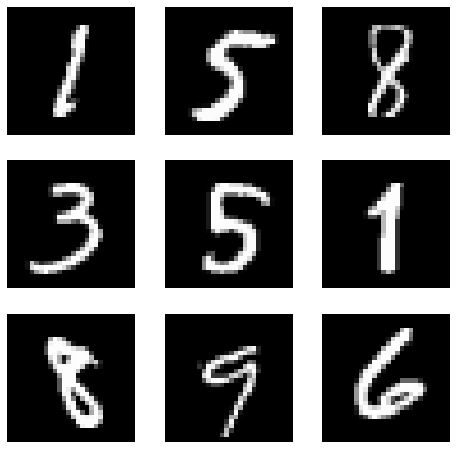

In [12]:
# Visualization of the images in the training set

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training the model

Now, we train the baseline model. 

Training for Epoch Number 1
Cost after iteration 200 : 3.2553117604612263
Cost after iteration 400 : 3.2413693537952373
Cost after iteration 600 : 3.238816922876523
Cost after iteration 800 : 3.243625623652493


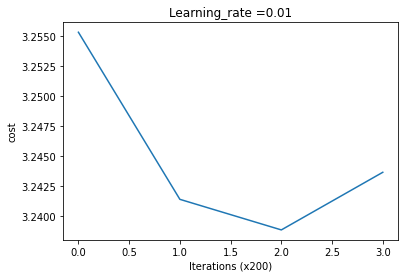

Training for Epoch Number 2
Cost after iteration 200 : 3.244865095335598
Cost after iteration 400 : 3.2324313666218227
Cost after iteration 600 : 3.232736257170238
Cost after iteration 800 : 3.2251845499775964


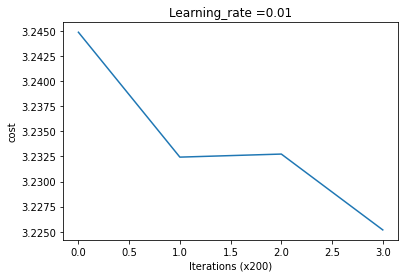

Training for Epoch Number 3
Cost after iteration 200 : 3.2383227796339478
Cost after iteration 400 : 3.212736414868955
Cost after iteration 600 : 3.245025760640505
Cost after iteration 800 : 3.2190026024309653


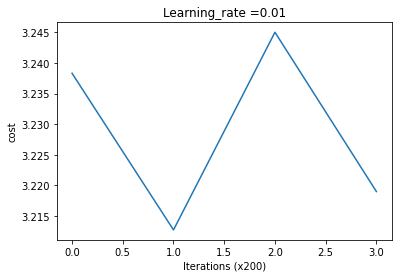

Training for Epoch Number 4
Cost after iteration 200 : 3.22227413799493
Cost after iteration 400 : 3.1809535105451188
Cost after iteration 600 : 3.1869377237428256
Cost after iteration 800 : 3.1874999878047525


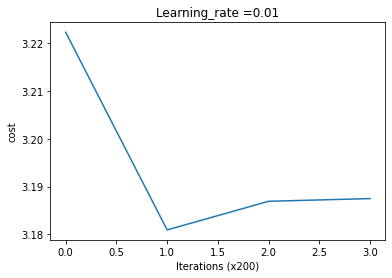

Training for Epoch Number 5
Cost after iteration 200 : 3.181884226867464
Cost after iteration 400 : 3.1605840568492667
Cost after iteration 600 : 3.1577774888251247
Cost after iteration 800 : 3.1698884424524874


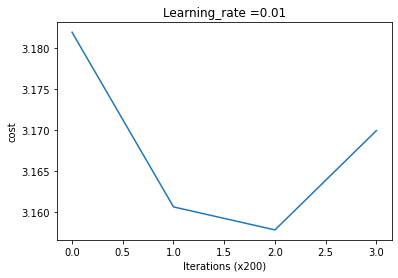

Training for Epoch Number 6
Cost after iteration 200 : 3.114978455488921
Cost after iteration 400 : 3.107308985638509
Cost after iteration 600 : 3.1301299110730327
Cost after iteration 800 : 3.059901031762709


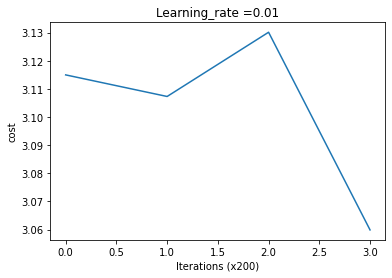

Training for Epoch Number 7
Cost after iteration 200 : 3.0648026637244135
Cost after iteration 400 : 3.036031015957269
Cost after iteration 600 : 3.026606546310572
Cost after iteration 800 : 2.918219837254589


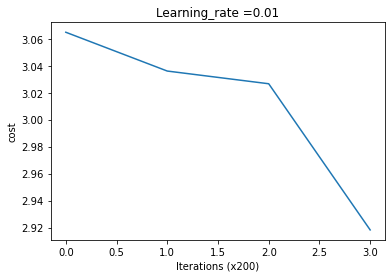

Training for Epoch Number 8
Cost after iteration 200 : 2.943499969716875
Cost after iteration 400 : 2.882237130647037
Cost after iteration 600 : 2.8300287744333517
Cost after iteration 800 : 2.663980036825982


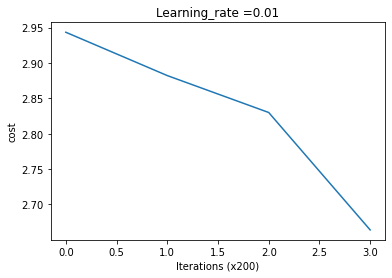

Training for Epoch Number 9
Cost after iteration 200 : 2.491609921932148
Cost after iteration 400 : 2.3600609520970757
Cost after iteration 600 : 2.3566154487102207
Cost after iteration 800 : 2.407130549240069


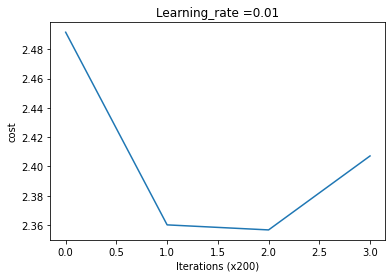

Training for Epoch Number 10
Cost after iteration 200 : 2.0827754932774694
Cost after iteration 400 : 2.066463544061059
Cost after iteration 600 : 1.9195813315485803
Cost after iteration 800 : 1.9022458338468335


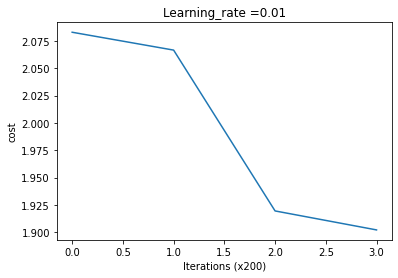

Training for Epoch Number 11
Cost after iteration 200 : 1.9292956601726994
Cost after iteration 400 : 1.908845658028921
Cost after iteration 600 : 1.8254878510365276
Cost after iteration 800 : 1.7281935417576626


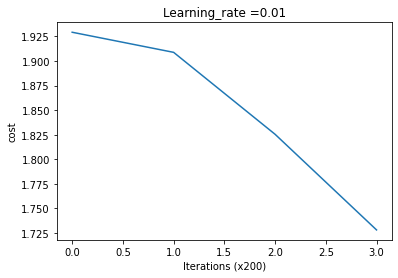

Training for Epoch Number 12
Cost after iteration 200 : 1.5591078746489933
Cost after iteration 400 : 1.371763507984131
Cost after iteration 600 : 1.5973380189909692
Cost after iteration 800 : 1.4145497478693674


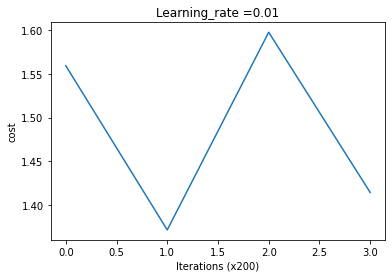

Training for Epoch Number 13
Cost after iteration 200 : 1.3008391544150255
Cost after iteration 400 : 1.4081033062196515
Cost after iteration 600 : 1.3661553419366244
Cost after iteration 800 : 1.4987598924240308


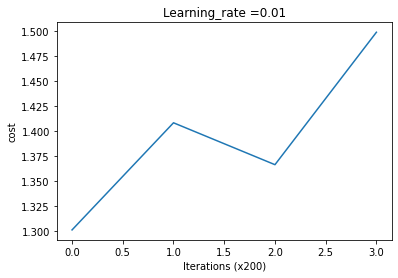

Training for Epoch Number 14
Cost after iteration 200 : 1.2441942225227423
Cost after iteration 400 : 1.2761487038595105
Cost after iteration 600 : 1.4235716349295626
Cost after iteration 800 : 1.3490131963121363


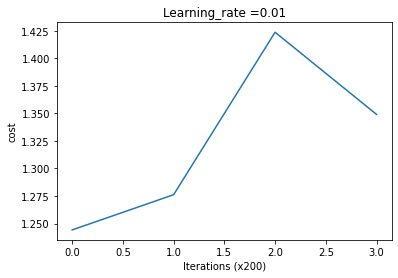

Training for Epoch Number 15
Cost after iteration 200 : 1.2950083208814327
Cost after iteration 400 : 1.5348799179930692
Cost after iteration 600 : 1.3780223558738642
Cost after iteration 800 : 1.0426952819639945


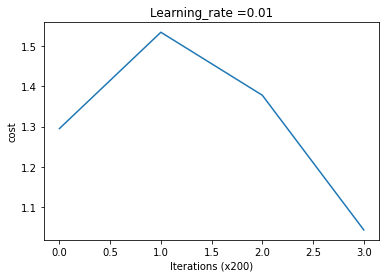

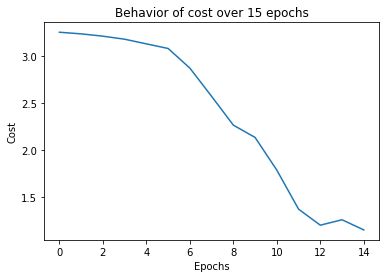

In [13]:
# The layer dimensions can changed, however the number of layers cannot!
layer_dims = [training_data.data.shape[1]**2, 500, 250, 100, 10]
baseline_model = epoch_model(training_data, layer_dims, num_epochs=15, batch_size=64, 
                            learning_rate=0.01, lambd=0, nonlinear=sigmoid,\
                                 der_nonlinear = der_sigmoid, 
                                 print_cost=True, 
                                 show_plot =True,
                                 show_train=True)

The model has now been trained and we have the trained weights and biases. These can be used for predictions on the test set to check how well the model has generalized. 

**Observation**

The above plots show how the cost function behaved each epoch for every $200$ iterations and how the cost behaved over $15$ epochs. The cost did not really change much for the first few epochs but steadily decreased for sure. This could mean that the baseline model might require more number of epochs to even further decrease the cost. 

## Performance Analysis of the Baseline Model

It is time to check how our trained baseline model performs with the test data. We will also check how it performs on the training data. 

### Train and Test Accuracy

Below, we get the train and test accuracy of the baseline model. 

In [14]:
train_pred = predict(training_data, baseline_model, sigmoid, test = False)
test_pred = predict(test_data, baseline_model, sigmoid, test = True)

Accuracy on the train data is : 79.01666666666667%
Accuracy on the test data is : 79.66%


**Observation**:

It seems the model generalizes quite well considering how both the train and test accuracy are close. However, the accuracy itself is lower. From the cost function plots, it can be seen that cost decreases over the epochs but slowly. This, as mentioned earlier could simply mean that the number of epochs required to get a higher accuracy would be more than $15$. Another observation that I made changing random seed initialization, training accuracy was always a bit lower than test accuracy, I am not sure if that is the case in general since my tests were not statistically significant.

### Classification Report

We use `sklearn.metrics` to get a `classification_report` method for further analysis.

In [15]:
y_true = test_pred[1] # predict() func outputs y_pred, y_true, accuracy
y_pred = test_pred[0]
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       980
           1       0.91      0.98      0.95      1135
           2       0.74      0.74      0.74      1032
           3       0.77      0.81      0.79      1010
           4       0.71      0.78      0.74       982
           5       0.72      0.61      0.66       892
           6       0.86      0.87      0.87       958
           7       0.87      0.84      0.85      1028
           8       0.74      0.67      0.70       974
           9       0.71      0.66      0.69      1009

    accuracy                           0.80     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.80      0.79     10000



From the `classification_report`, we can see that some digits are harder to learn or generalize (refer to the precision and recall for each digit) like $4, 5, 8$ and $9$. Knowing this and given the condition that we are stuck with current specifications of the baseline model, we can try to supply more examples for these digits and see if that helps the model to learn the *harder* digits better.

## Activation Functions

Two other activation functions were defined earlier $-$ `relu` and `tanh`. Let's check how just changing the activation function affects the performance of the model. 

### Tanh Activation Model

Now, we use `tanh` activation for the nonlinear operations in the neural network. We will plot the cost function, get the accuracy as well as the classification report.

Training for Epoch Number 1
Cost after iteration 200 : 1.1872032873745164
Cost after iteration 400 : 0.7672646833932542
Cost after iteration 600 : 0.7318548676386455
Cost after iteration 800 : 0.5708177866059059


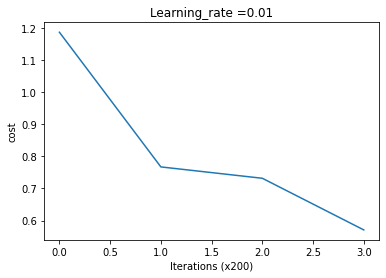

Training for Epoch Number 2
Cost after iteration 200 : 0.643917366393649
Cost after iteration 400 : 0.700713122888269
Cost after iteration 600 : 0.7434565073457811
Cost after iteration 800 : 0.5109168912541341


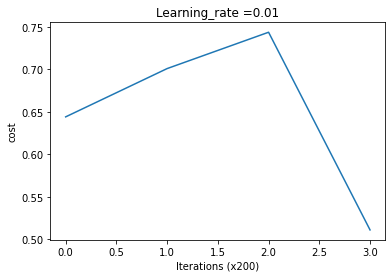

Training for Epoch Number 3
Cost after iteration 200 : 0.3260163156835599
Cost after iteration 400 : 0.37747313467224675
Cost after iteration 600 : 0.44958467836460625
Cost after iteration 800 : 0.3750511660420366


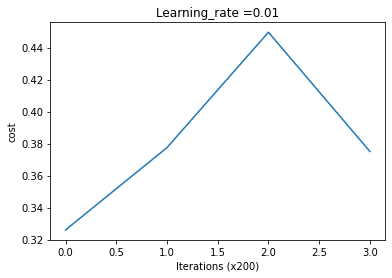

Training for Epoch Number 4
Cost after iteration 200 : 0.3938695565259212
Cost after iteration 400 : 0.6591495690767388
Cost after iteration 600 : 0.43341927791310264
Cost after iteration 800 : 0.30062306856884113


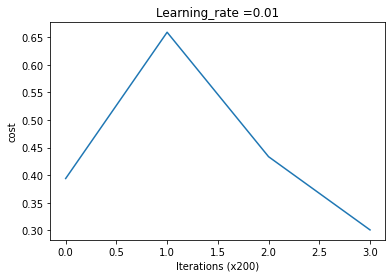

Training for Epoch Number 5
Cost after iteration 200 : 0.5543976483462338
Cost after iteration 400 : 0.3985574315472454
Cost after iteration 600 : 0.26498585419248866
Cost after iteration 800 : 0.35650711506529387


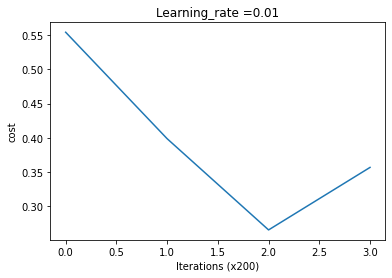

Training for Epoch Number 6
Cost after iteration 200 : 0.28904274065974067
Cost after iteration 400 : 0.4543763184985637
Cost after iteration 600 : 0.17917884474636292
Cost after iteration 800 : 0.44647747444162333


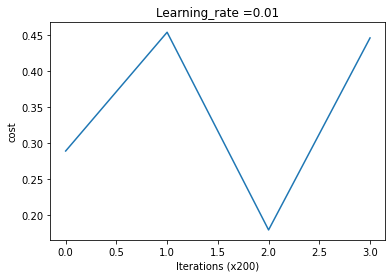

Training for Epoch Number 7
Cost after iteration 200 : 0.43381087492737436
Cost after iteration 400 : 0.33012549598493024
Cost after iteration 600 : 0.3531865774808016
Cost after iteration 800 : 0.4332623905413762


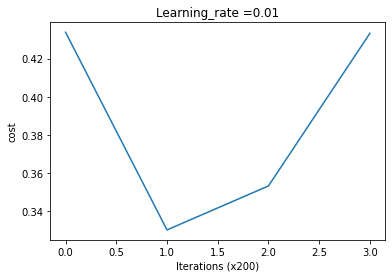

Training for Epoch Number 8
Cost after iteration 200 : 0.4307096177982346
Cost after iteration 400 : 0.4239070458568865
Cost after iteration 600 : 0.38491371400054264
Cost after iteration 800 : 0.19277834661573717


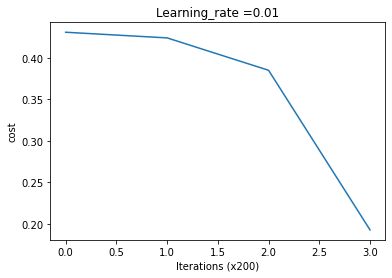

Training for Epoch Number 9
Cost after iteration 200 : 0.4271414686891081
Cost after iteration 400 : 0.32069009792806097
Cost after iteration 600 : 0.31653252670026955
Cost after iteration 800 : 0.41029076676736376


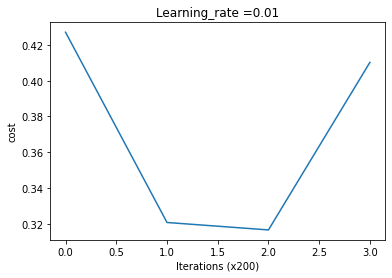

Training for Epoch Number 10
Cost after iteration 200 : 0.18359350575258135
Cost after iteration 400 : 0.210382811623943
Cost after iteration 600 : 0.41907443189610005
Cost after iteration 800 : 0.388347205607246


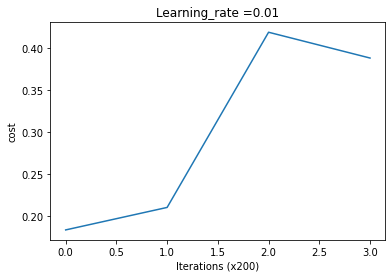

Training for Epoch Number 11
Cost after iteration 200 : 0.5067303117819638
Cost after iteration 400 : 0.4454640686321323
Cost after iteration 600 : 0.3738603428950593
Cost after iteration 800 : 0.40385502280901125


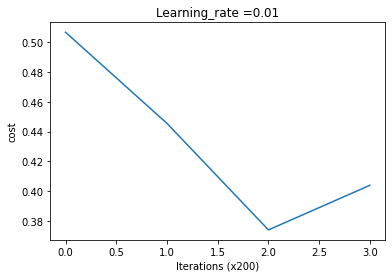

Training for Epoch Number 12
Cost after iteration 200 : 0.2192793226506431
Cost after iteration 400 : 0.12703812340867415
Cost after iteration 600 : 0.231708531466302
Cost after iteration 800 : 0.20192371246374996


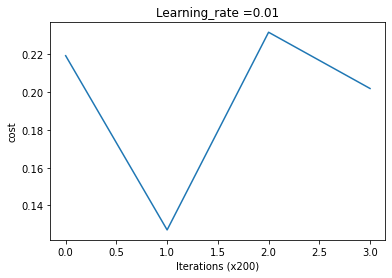

Training for Epoch Number 13
Cost after iteration 200 : 0.09219185183177159
Cost after iteration 400 : 0.16990883303091975
Cost after iteration 600 : 0.2209012914298499
Cost after iteration 800 : 0.34544731635857434


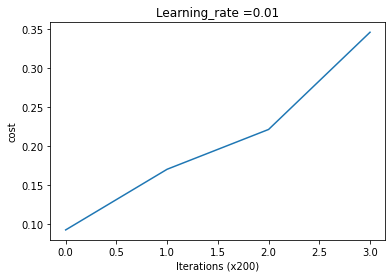

Training for Epoch Number 14
Cost after iteration 200 : 0.29189624768860845
Cost after iteration 400 : 0.3414523850260499
Cost after iteration 600 : 0.13280236416029978
Cost after iteration 800 : 0.5246829525420205


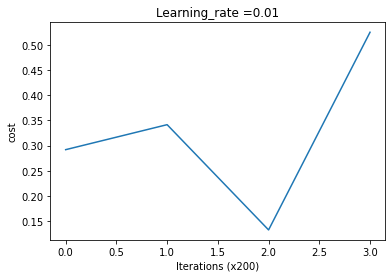

Training for Epoch Number 15
Cost after iteration 200 : 0.09375512403033898
Cost after iteration 400 : 0.29744179562536216
Cost after iteration 600 : 0.3309025385637192
Cost after iteration 800 : 0.22863702525150145


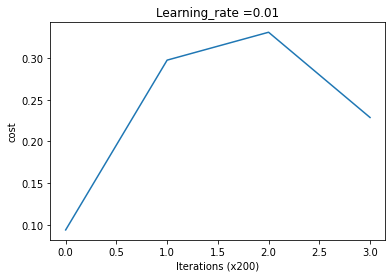

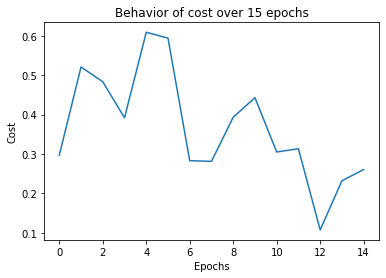

In [16]:
tanh_model = epoch_model(training_data, layer_dims, num_epochs=15, batch_size=64, 
                            learning_rate=0.01, lambd=0, nonlinear=tanh,\
                                 der_nonlinear = der_tanh, 
                                 print_cost=True, 
                                 show_plot =True,
                                 show_train=True)

In [17]:
tanh_train_pred = predict(training_data, tanh_model, tanh, test = False)
tanh_test_pred = predict(test_data, tanh_model, tanh, test = True)
print(metrics.classification_report(tanh_test_pred[1], tanh_test_pred[0]))

Accuracy on the train data is : 95.92500000000001%
Accuracy on the test data is : 95.47%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.96      0.94      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.95      0.95      0.95       892
           6       0.95      0.96      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.94      0.94       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



`tanh_model` is a definitve improvement over `baseline_model`. Here, we can see that some of the digits which were *harder* to learn have been learnt significantly better. Overall accuracy of the model has also significantly jumped. Let's check if `relu` brings even more improvements.

### ReLU Activation Model

Here, we use `relu` activation for the nonlinear operations in the neural network. We will plot the cost function, get the accuracy as well as the classification report.

Training for Epoch Number 1
Cost after iteration 200 : 1.5853492123113027
Cost after iteration 400 : 0.8503917461073123
Cost after iteration 600 : 0.6330047147682037
Cost after iteration 800 : 0.5594995777281522


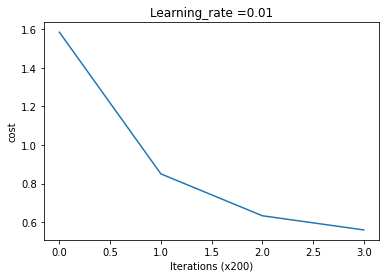

Training for Epoch Number 2
Cost after iteration 200 : 0.4174675572951949
Cost after iteration 400 : 0.25232765408311786
Cost after iteration 600 : 0.5724997567718167
Cost after iteration 800 : 0.3287854523160577


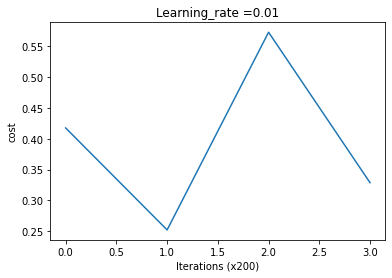

Training for Epoch Number 3
Cost after iteration 200 : 0.30752170349829966
Cost after iteration 400 : 0.4469519096315443
Cost after iteration 600 : 0.47857647584504664
Cost after iteration 800 : 0.24188794000798244


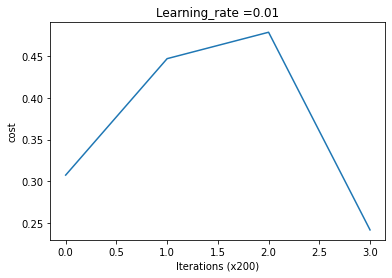

Training for Epoch Number 4
Cost after iteration 200 : 0.6030971348447945
Cost after iteration 400 : 0.49561289024926963
Cost after iteration 600 : 0.3933049315232083
Cost after iteration 800 : 0.22339681592949306


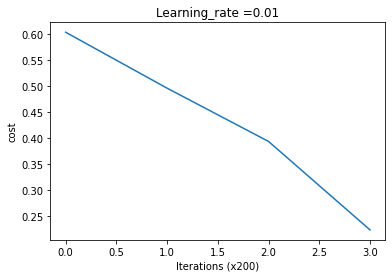

Training for Epoch Number 5
Cost after iteration 200 : 0.4575673621207358
Cost after iteration 400 : 0.16419065813986805
Cost after iteration 600 : 0.2799341116026553
Cost after iteration 800 : 0.17427635563700827


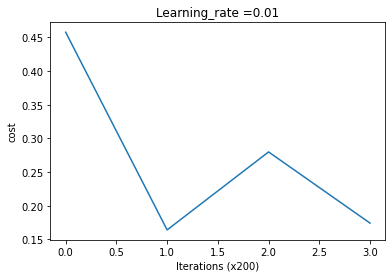

Training for Epoch Number 6
Cost after iteration 200 : 0.3708708228577067
Cost after iteration 400 : 0.43692684082243316
Cost after iteration 600 : 0.3610818589771365
Cost after iteration 800 : 0.25103214817484865


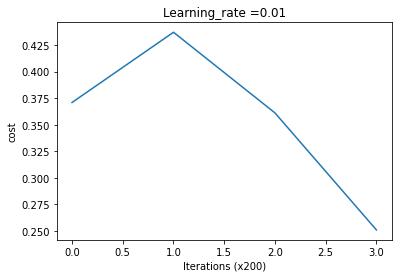

Training for Epoch Number 7
Cost after iteration 200 : 0.13841394274742713
Cost after iteration 400 : 0.22006106206441672
Cost after iteration 600 : 0.16471227075633377
Cost after iteration 800 : 0.3576810438824678


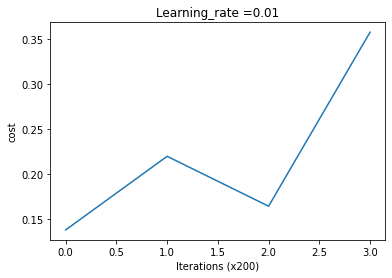

Training for Epoch Number 8
Cost after iteration 200 : 0.28248038097762485
Cost after iteration 400 : 0.1378574535660312
Cost after iteration 600 : 0.1334943731049229
Cost after iteration 800 : 0.07606273890911061


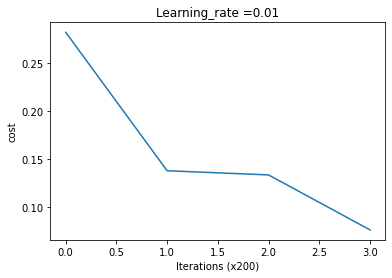

Training for Epoch Number 9
Cost after iteration 200 : 0.3566738324212042
Cost after iteration 400 : 0.303430117008281
Cost after iteration 600 : 0.2673680738673194
Cost after iteration 800 : 0.3078904771963884


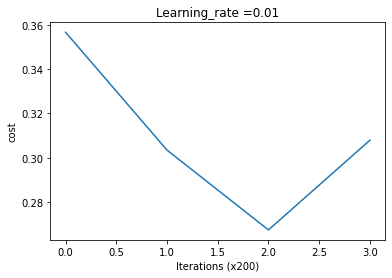

Training for Epoch Number 10
Cost after iteration 200 : 0.15122035420291485
Cost after iteration 400 : 0.27155513631172734
Cost after iteration 600 : 0.17641095594052802
Cost after iteration 800 : 0.2191074996976169


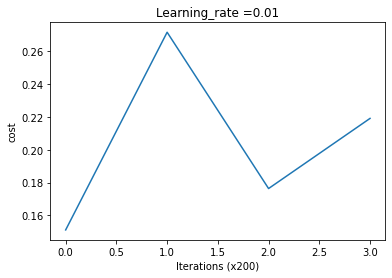

Training for Epoch Number 11
Cost after iteration 200 : 0.16770978654016677
Cost after iteration 400 : 0.11837867500201915
Cost after iteration 600 : 0.310707150781077
Cost after iteration 800 : 0.12605972985635108


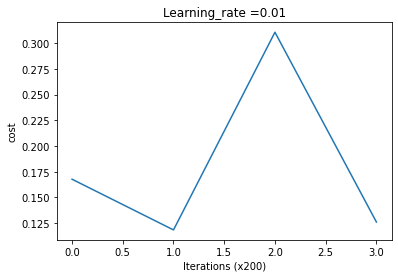

Training for Epoch Number 12
Cost after iteration 200 : 0.12968477434355008
Cost after iteration 400 : 0.0935533199294832
Cost after iteration 600 : 0.03379634664344545
Cost after iteration 800 : 0.09579232113738446


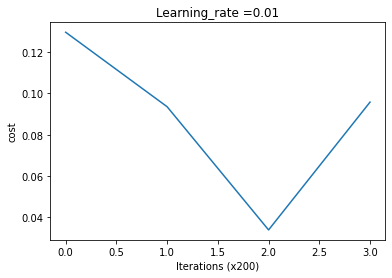

Training for Epoch Number 13
Cost after iteration 200 : 0.12527111207820799
Cost after iteration 400 : 0.44536974655549577
Cost after iteration 600 : 0.07671606721426938
Cost after iteration 800 : 0.11946879143508995


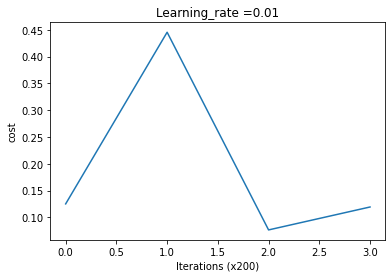

Training for Epoch Number 14
Cost after iteration 200 : 0.18094002328639147
Cost after iteration 400 : 0.08062690891104206
Cost after iteration 600 : 0.061671714913615054
Cost after iteration 800 : 0.16319347978554966


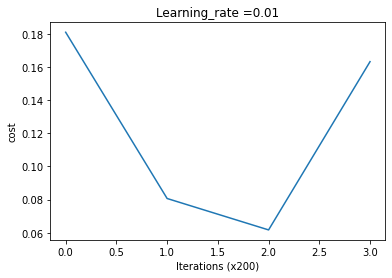

Training for Epoch Number 15
Cost after iteration 200 : 0.10203206667775225
Cost after iteration 400 : 0.11198774140139162
Cost after iteration 600 : 0.21178818916688494
Cost after iteration 800 : 0.052552293270239046


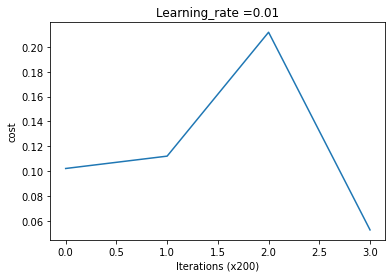

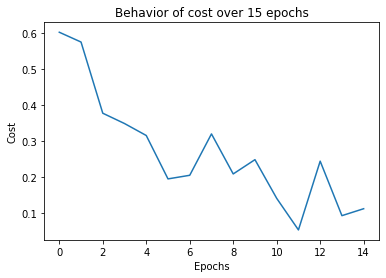

In [18]:
relu_model = epoch_model(training_data, layer_dims, num_epochs=15, batch_size=64, 
                            learning_rate=0.01, lambd=0, nonlinear=relu,\
                                 der_nonlinear = der_relu, 
                                 print_cost=True, 
                                 show_plot =True,
                                 show_train=True)

In [19]:
relu_train_pred = predict(training_data, relu_model, relu, test = False)
relu_test_pred = predict(test_data, relu_model, relu, test = True)
print(metrics.classification_report(relu_test_pred[1], relu_test_pred[0]))

Accuracy on the train data is : 97.88666666666667%
Accuracy on the test data is : 96.94%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



It seems that `relu_model` performs the best. Just changing the activation function has improved the accuracy of the model significantly. One other observation to be made is how the cost behaved over epochs for `baseline_model`, `tanh_model` and `relu_model`. The cost for latter two oscillated between epochs but that was not the case for `baseline_model` which decreased steadily. However, `relu_model` is the best model overall.

In [20]:
best_model = relu_model

# PyTorch Equivalent of the Best Model

From the previous sections, it has been established that the model which used **ReLU** activation function performed the best keeping all the other hyperparameters the same. Now, we can implement the same model using PyTorch. 

## Defining utility functions

A `NeuralNetwork` class defines the model's architecture following exactly the same architecture as `best_model`. The weight initialization is set to `Xavier` for fair comparison as the default initialization for weights in `PyTorch` is `He` initialization. 

In [21]:
# The model defined has the same architecture as the best_model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(nn.Linear(28*28, 500, bias=True), \
                                              nn.ReLU(),
                                              nn.Linear(500,250, bias=True),
                                              nn.ReLU(),
                                              nn.Linear(250,100, bias=True),
                                              nn.ReLU(),
                                              nn.Linear(100,10, bias=True))
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# The default initialization in PyTorch is He initialization
# To fairly compare with the model we made from scratch 
# Both should at least have same initialization
def init_weights(x):
    if isinstance(x, nn.Linear):
        torch.nn.init.xavier_uniform_(x.weight)
        x.bias.data.fill_(0)

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    costs=[]
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 200 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            costs.append(loss)
        
    plt.plot(costs)
    plt.xlabel('Training Example')
    plt.ylabel('Cost')
    plt.title('Learning Rate = 0.01')

    plt.show()
    return costs[-1]

# Test loop to get accuracy over test every epoch
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Loading data

`DataLoader` function is used to get train and test split along with batch size of 64.

In [22]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

## Hyperparameter initialization

- **Batch Size**: $64$
- **Learning Rate**: $0.01$
- **Number of Epochs**: $15$
- **Activation Function**: `relu`
- **Loss Function**: `CrossEntropy`
- **Regularized**: `False`
- **Weight Initialization**: `Glorot/Xavier`
- **Optimizer**: `Adam`

In [23]:
model = NeuralNetwork()

# Apply Glorot initialization
model.apply(init_weights)

# Same hyperparameters as the best_model
learning_rate = 0.01
batch_size = 64
epochs = 15

# Loss is CrossEntropy
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Using Adam optimizer as required by the assignment
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training and Accuracy Metrics

Now, we train the equivalent model and obtain the accuracy metrics. 

Epoch 1
-------------------------------
loss: 2.312906  [    0/60000]
loss: 0.394369  [12800/60000]
loss: 0.057268  [25600/60000]
loss: 0.163631  [38400/60000]
loss: 0.227255  [51200/60000]


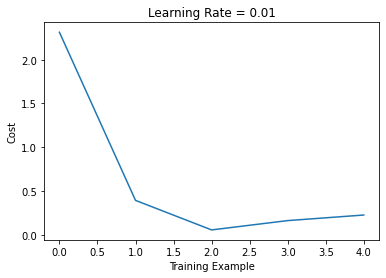

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.185759 

Epoch 2
-------------------------------
loss: 0.153432  [    0/60000]
loss: 0.203611  [12800/60000]
loss: 0.157616  [25600/60000]
loss: 0.138005  [38400/60000]
loss: 0.148068  [51200/60000]


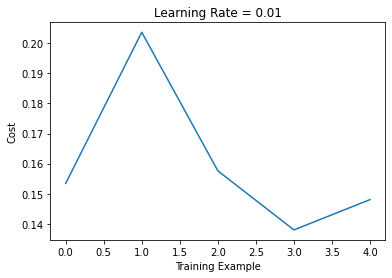

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.318430 

Epoch 3
-------------------------------
loss: 0.198214  [    0/60000]
loss: 0.177429  [12800/60000]
loss: 0.161689  [25600/60000]
loss: 0.172218  [38400/60000]
loss: 0.394766  [51200/60000]


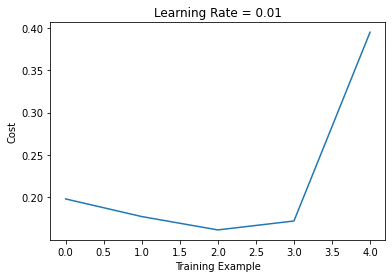

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.197871 

Epoch 4
-------------------------------
loss: 0.074793  [    0/60000]
loss: 0.174549  [12800/60000]
loss: 0.142932  [25600/60000]
loss: 0.195168  [38400/60000]
loss: 0.212597  [51200/60000]


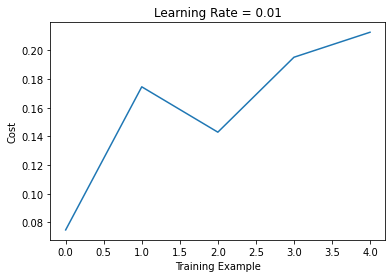

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.201976 

Epoch 5
-------------------------------
loss: 0.069945  [    0/60000]
loss: 0.097235  [12800/60000]
loss: 0.166837  [25600/60000]
loss: 0.143060  [38400/60000]
loss: 0.286211  [51200/60000]


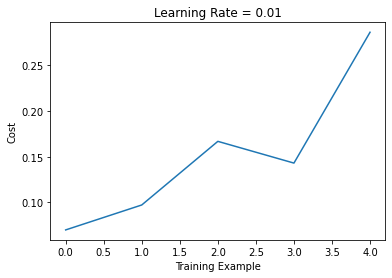

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.189361 

Epoch 6
-------------------------------
loss: 0.057408  [    0/60000]
loss: 0.029503  [12800/60000]
loss: 0.306353  [25600/60000]
loss: 0.097976  [38400/60000]
loss: 0.212135  [51200/60000]


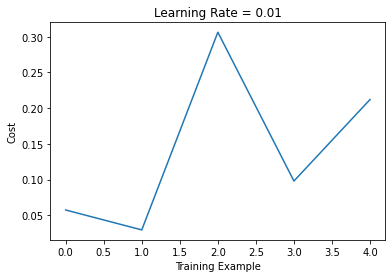

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.232423 

Epoch 7
-------------------------------
loss: 0.148765  [    0/60000]
loss: 0.323904  [12800/60000]
loss: 0.032111  [25600/60000]
loss: 0.039205  [38400/60000]
loss: 0.261176  [51200/60000]


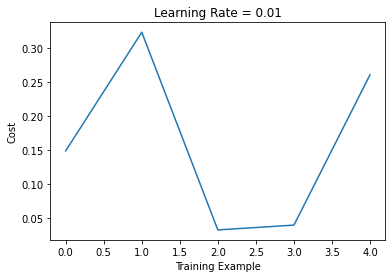

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.227007 

Epoch 8
-------------------------------
loss: 0.058986  [    0/60000]
loss: 0.131313  [12800/60000]
loss: 0.156548  [25600/60000]
loss: 0.081806  [38400/60000]
loss: 0.298915  [51200/60000]


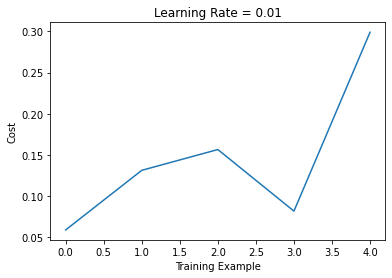

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.201171 

Epoch 9
-------------------------------
loss: 0.083435  [    0/60000]
loss: 0.042329  [12800/60000]
loss: 0.087834  [25600/60000]
loss: 0.098694  [38400/60000]
loss: 0.290051  [51200/60000]


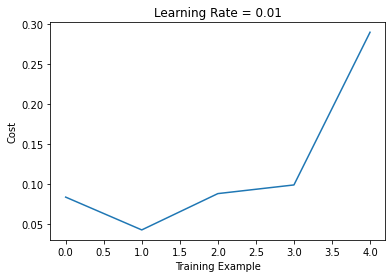

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.161849 

Epoch 10
-------------------------------
loss: 0.148275  [    0/60000]
loss: 0.027424  [12800/60000]
loss: 0.032980  [25600/60000]
loss: 0.059770  [38400/60000]
loss: 0.439084  [51200/60000]


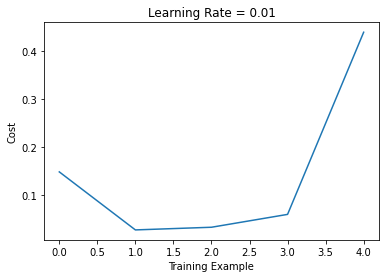

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.233525 

Epoch 11
-------------------------------
loss: 0.075799  [    0/60000]
loss: 0.038790  [12800/60000]
loss: 0.093981  [25600/60000]
loss: 0.229996  [38400/60000]
loss: 0.077525  [51200/60000]


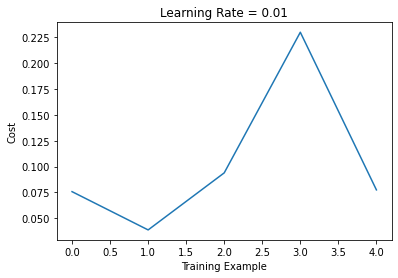

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.177935 

Epoch 12
-------------------------------
loss: 0.046073  [    0/60000]
loss: 0.106128  [12800/60000]
loss: 0.126693  [25600/60000]
loss: 0.114033  [38400/60000]
loss: 0.250782  [51200/60000]


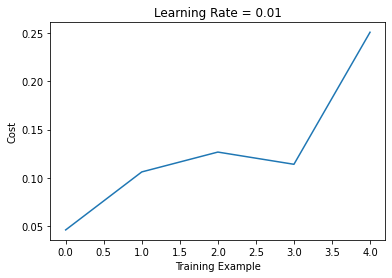

Test Error: 
 Accuracy: 96.4%, Avg loss: 0.210514 

Epoch 13
-------------------------------
loss: 0.023362  [    0/60000]
loss: 0.145284  [12800/60000]
loss: 0.695097  [25600/60000]
loss: 0.094421  [38400/60000]
loss: 0.235781  [51200/60000]


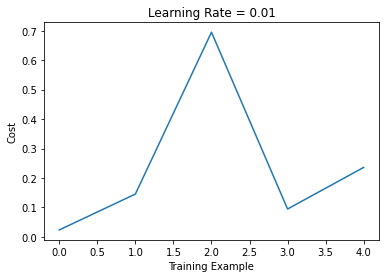

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.185927 

Epoch 14
-------------------------------
loss: 0.121545  [    0/60000]
loss: 0.146501  [12800/60000]
loss: 0.260724  [25600/60000]
loss: 0.045096  [38400/60000]
loss: 0.246905  [51200/60000]


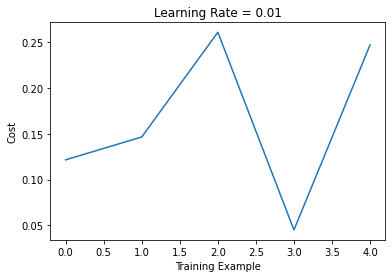

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.173019 

Epoch 15
-------------------------------
loss: 0.020595  [    0/60000]
loss: 0.256726  [12800/60000]
loss: 0.066982  [25600/60000]
loss: 0.132920  [38400/60000]
loss: 0.241406  [51200/60000]


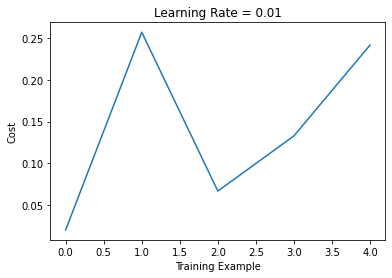

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.194160 



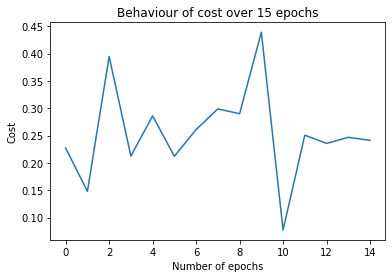

In [24]:
epoch_costs=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train=train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    epoch_costs.append(train)

plt.plot(epoch_costs)
plt.xlabel("Number of epochs")
plt.ylabel("Cost")
plt.title("Behaviour of cost over 15 epochs")

plt.show()

We see that the `PyTorch` model has given almost the same test accuracy as the model we coded from scratch. However, it trains much faster as compared to the scratch model probably due to the choice of optimizer and under the hood optimizations in the package itself.

## Regularized Model

To improve generalization accuracy and prevent the model from overfitting the training set, we can add regularization to the backward propagation algorithm. We can now check if `best_model` performs better on test set if regularization is done. Here, we use $L_{2}$ regularization. Just changing the value of `lambd` to some value greater than $0$ would regularize the model. However, there has to be some optimal value for `lambd` such that there is a balance in capacity and the generalization ability of the model.


Training for Epoch Number 1
Cost after iteration 200 : 1.921691171363094
Cost after iteration 400 : 1.2010296739338582
Cost after iteration 600 : 0.8751268228403619
Cost after iteration 800 : 0.4427283613803552


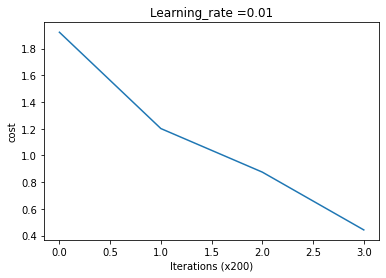

Training for Epoch Number 2
Cost after iteration 200 : 0.5487753300968103
Cost after iteration 400 : 0.4297731787926241
Cost after iteration 600 : 0.7890756176756167
Cost after iteration 800 : 0.6191274861783552


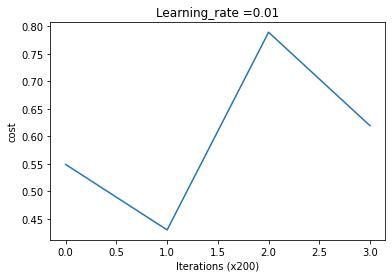

Training for Epoch Number 3
Cost after iteration 200 : 0.629187268100183
Cost after iteration 400 : 0.4470556888860723
Cost after iteration 600 : 0.5614872730620775
Cost after iteration 800 : 0.588295833660319


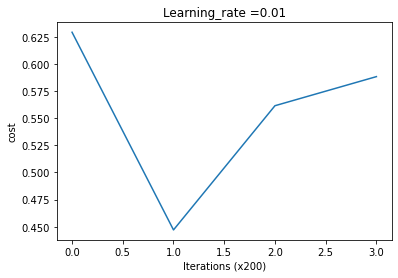

Training for Epoch Number 4
Cost after iteration 200 : 0.4019912774021217
Cost after iteration 400 : 0.29732292247011677
Cost after iteration 600 : 0.38521337674775646
Cost after iteration 800 : 0.5386974178767678


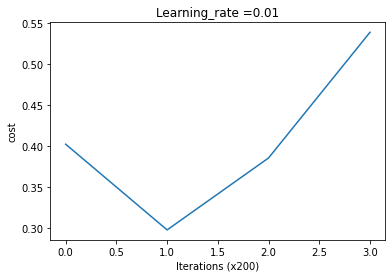

Training for Epoch Number 5
Cost after iteration 200 : 0.4054562052648761
Cost after iteration 400 : 0.34813120832768285
Cost after iteration 600 : 0.3436033781643477
Cost after iteration 800 : 0.4241443067928701


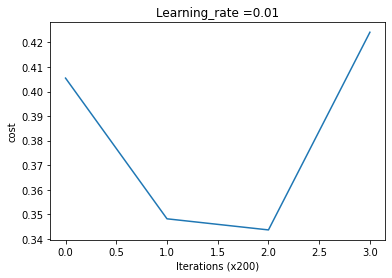

Training for Epoch Number 6
Cost after iteration 200 : 0.5251386991434732
Cost after iteration 400 : 0.5441049775594764
Cost after iteration 600 : 0.5692020543125094
Cost after iteration 800 : 0.44252122844777275


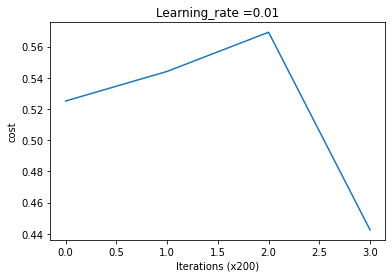

Training for Epoch Number 7
Cost after iteration 200 : 0.4251830842474056
Cost after iteration 400 : 0.38702588813692473
Cost after iteration 600 : 0.4156866844067752
Cost after iteration 800 : 0.5808985181551343


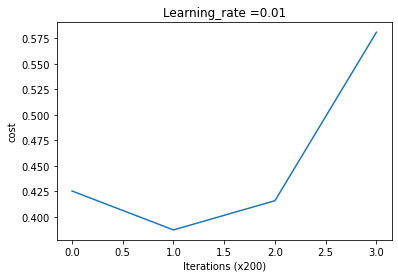

Training for Epoch Number 8
Cost after iteration 200 : 0.533627995462873
Cost after iteration 400 : 0.7811864533042518
Cost after iteration 600 : 0.31128736598160744
Cost after iteration 800 : 0.3805287036188477


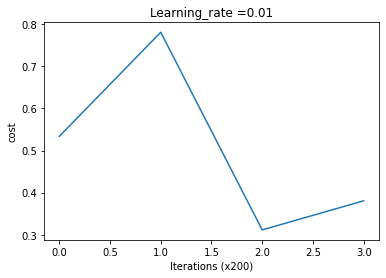

Training for Epoch Number 9
Cost after iteration 200 : 0.528941322317743
Cost after iteration 400 : 0.6164911291587707
Cost after iteration 600 : 0.41578193228855675
Cost after iteration 800 : 0.5981413556300255


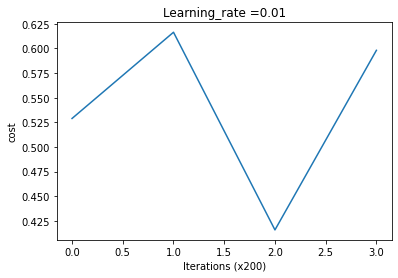

Training for Epoch Number 10
Cost after iteration 200 : 0.4763149715527889
Cost after iteration 400 : 0.4683875750420305
Cost after iteration 600 : 0.39542775542300945
Cost after iteration 800 : 0.44455579998699735


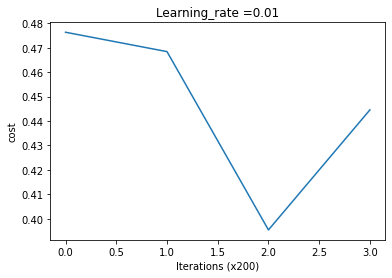

Training for Epoch Number 11
Cost after iteration 200 : 0.6233578865051213
Cost after iteration 400 : 0.5186653113317176
Cost after iteration 600 : 0.35775002803839795
Cost after iteration 800 : 0.49887359369737116


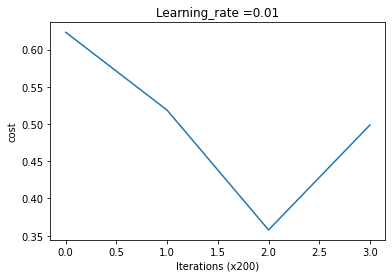

Training for Epoch Number 12
Cost after iteration 200 : 0.587392007263277
Cost after iteration 400 : 0.4029743206979053
Cost after iteration 600 : 0.531936377621365
Cost after iteration 800 : 0.40519176989702277


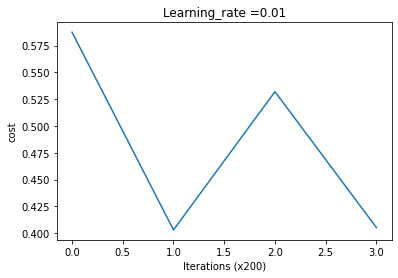

Training for Epoch Number 13
Cost after iteration 200 : 0.3105387689093293
Cost after iteration 400 : 0.38512094632741667
Cost after iteration 600 : 0.33862109237316196
Cost after iteration 800 : 0.37496675316151007


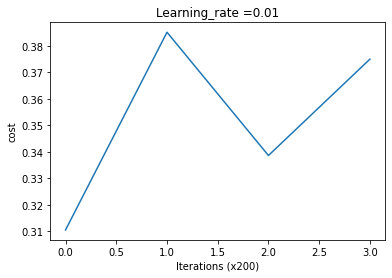

Training for Epoch Number 14
Cost after iteration 200 : 0.4369755157354851
Cost after iteration 400 : 0.6317832196358568
Cost after iteration 600 : 0.3382360305391861
Cost after iteration 800 : 0.4286730242255878


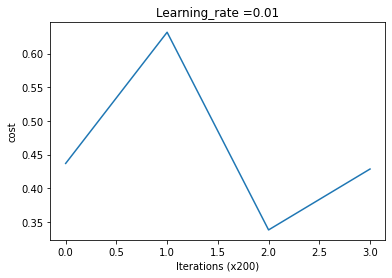

Training for Epoch Number 15
Cost after iteration 200 : 0.3441261642144566
Cost after iteration 400 : 0.27109409266374723
Cost after iteration 600 : 0.37338241106940273
Cost after iteration 800 : 0.387951171584271


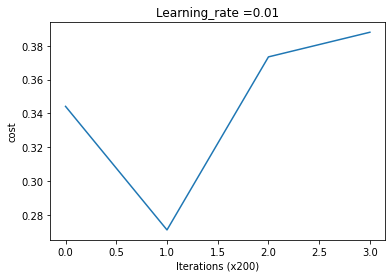

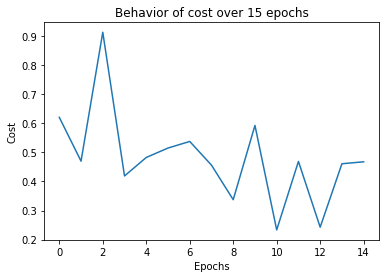

In [33]:
# Trying out lambd=0.7
regularized_best_model = epoch_model(training_data, layer_dims, num_epochs=15, batch_size=64, 
                            learning_rate=0.01, lambd=0.8, nonlinear=relu,\
                                 der_nonlinear = der_relu, 
                                 print_cost=True, 
                                 show_plot =True,
                                 show_train=True)

Let's check how the model performs now on the test set.

In [34]:
reg_best_train_pred = predict(training_data, regularized_best_model, relu, test = False)
reg_best_test_pred = predict(test_data, regularized_best_model, relu, test = True)
print(metrics.classification_report(reg_best_test_pred[1], reg_best_test_pred[0]))

Accuracy on the train data is : 94.27166666666666%
Accuracy on the test data is : 94.28%
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.92      0.96      0.94      1010
           4       0.94      0.94      0.94       982
           5       0.94      0.92      0.93       892
           6       0.96      0.94      0.95       958
           7       0.96      0.92      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



The regularized model has improved the test accuracy at the cost of reduction in training accuracy. At the same time the accuracy has reduced which could mean that this value of `lambd` is not optimal as it has hindered the learning capacity of the model. An optimal `lambd` value would strike a balance between generalization (more accuracy over unseen test examples) and the learning capacity of the model. It is also possible we might to choose a different regularization method for this to get the perfect balance between the two. 

# Conclusion

In this assignment, we coded a neural network from scratch to perform the task of handwritten digit recognition for the `MNIST` dataset. Given a baseline model architecture and hyperparameters, we improved significantly to better models just by changing the activation function and introducing regularization. We also see how modern `Python` packages like `PyTorch` are more convenient to use and tune for better performance. Our scratch model performs almost just as well as the PyTorch model however, it takes much longer to train. 

Other experiments could also be done to further improve the `best_model` such as increasing the number of neurons in each layer would help us better approximate the functional relationship between input and output (*Universal Approximation Theorem*) along with regularization. Change in learning rate could also significantly improve performance and help escape local minimas. 